## Introduction

In this notebook we are going to explore one dataset that has data about an FPSO vessel. Here we have cases that failed and normal ones, we are going to explore the given variables and create a model to predict fail.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from itertools import compress
import numpy as np
#from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,10)})

/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_excel("O_G_Equipment_Data.xlsx")

## EDA - Exploratorian Data Analyses

Let's take a first look in our data to see what we are dealing with, and what are our first impressions.

In [3]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [4]:
df['Fail'].value_counts()

False    734
True      66
Name: Fail, dtype: int64

In [5]:
# What are the types of data we have? Does it need any change?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


The target variable is a boolean and the others are int or float.

In [6]:
df["Target"] = df['Fail'].astype(int)
df.drop("Fail", axis=1, inplace=True)

# Creating a setup feature, it's the combination of Preset_1 and Preset_2
df["Setup"] = df["Preset_1"].astype(str) + "_" + df["Preset_2"].astype(str)

df.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Target
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449,0.082500
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702,0.275297
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101,0.000000
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762,0.000000
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252,0.000000
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457,0.000000
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303,1.000000


From this first look we can see there is a big gap between the q75 and the max value, and the max value is way bigger than the mean + 2*std. If they are normally distributed it means they all have outliers, but we don't know how many, just that it is in the latter quarter.


In [7]:
columns = df.columns

for col in columns:
    print(col+" - number of unique values: ", df[col].nunique())

Cycle - number of unique values:  800
Preset_1 - number of unique values:  3
Preset_2 - number of unique values:  8
Temperature - number of unique values:  800
Pressure - number of unique values:  800
VibrationX - number of unique values:  800
VibrationY - number of unique values:  800
VibrationZ - number of unique values:  800
Frequency - number of unique values:  800
Target - number of unique values:  2
Setup - number of unique values:  24


As expected we have 2 categorical variables, Preset_1 and Preset_2, the target is a boolean one and the rest are numerical ones.

In [8]:
for col in columns:
    print(df[col].value_counts())

1      1
538    1
528    1
529    1
530    1
      ..
270    1
271    1
272    1
273    1
800    1
Name: Cycle, Length: 800, dtype: int64
2    281
1    264
3    255
Name: Preset_1, dtype: int64
7    109
6    101
3    101
2    101
5    100
8    100
1     95
4     93
Name: Preset_2, dtype: int64
44.235186     1
74.816930     1
69.351405     1
61.559512     1
44.617627     1
             ..
106.468516    1
106.588913    1
100.992611    1
39.074863     1
80.854011     1
Name: Temperature, Length: 800, dtype: int64
47.657254     1
73.487684     1
163.909901    1
54.608816     1
100.089202    1
             ..
89.151486     1
129.416385    1
99.520612     1
44.324061     1
110.543701    1
Name: Pressure, Length: 800, dtype: int64
46.441769     1
130.062273    1
96.634754     1
145.525140    1
135.662143    1
             ..
129.768607    1
90.798140     1
100.177405    1
34.437929     1
121.032227    1
Name: VibrationX, Length: 800, dtype: int64
64.820327     1
75.402959     1
63.607018     

From the data above we can see the setup variables are balanced and the target one is not. 
We have 66 True fails, it represents 8,25% of our data and we have 11,12 times more Falses than Trues.


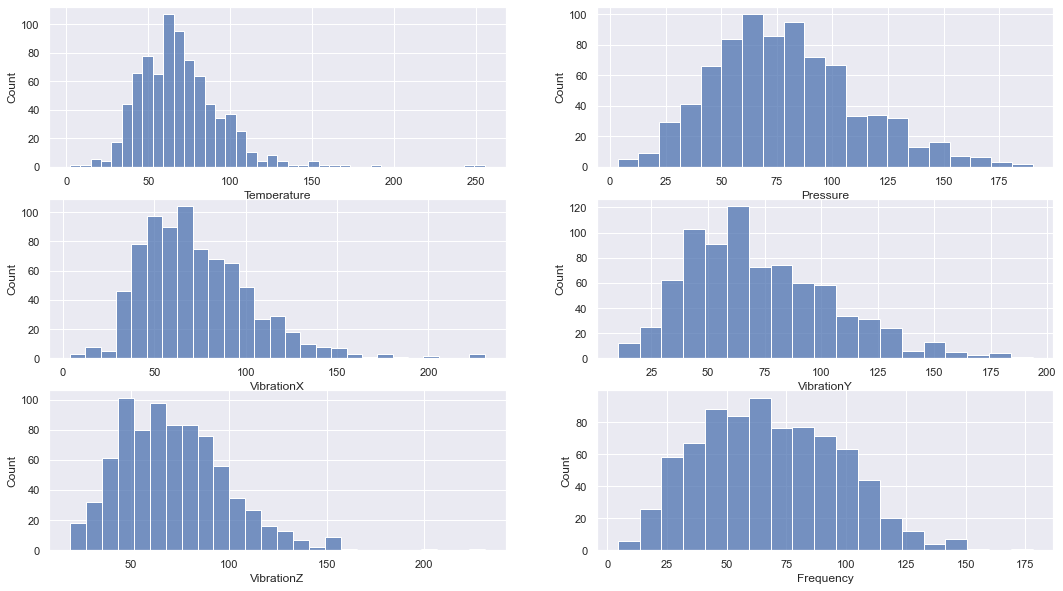

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(18, 10))
numerical_cols = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

for c, ax in zip(numerical_cols, axes.flat):
    sns.histplot(df[c], ax=ax)
plt.show()

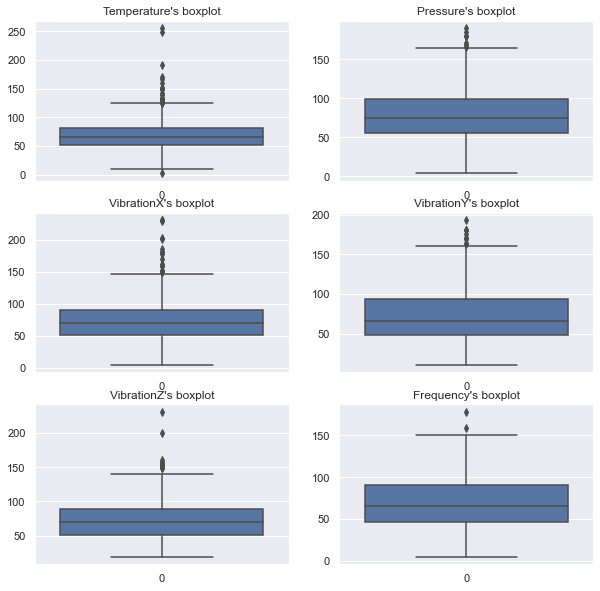

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

for c, ax in zip(numerical_cols, axes.flat):
    ax.set_title(c + "'s boxplot")
    sns.boxplot(data=df[c], ax=ax)
plt.show()

Looking the graphs above we have high suspition those distribution can't be treated as normal, some for the long tail on the left and the other for the heavy tail. To confirme this we are going to the a normal test.


Our Null Hyphotesis is a normal distribution, the alternative Hyphotesis is that is another distribution.

In [11]:
def normal_test(data):
    stat, p = normaltest(data)
    print('Statistics=%.2f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('We fail to reject H0: Sample looks Gaussian')
    else:
        print('We reject H0: Sample does not look Gaussian')

In [12]:
# Normal test to check if the variables are normally distributed.

for c in numerical_cols:
    normal_test(df[c])

Statistics=304.42, p=0.000
We reject H0: Sample does not look Gaussian
Statistics=36.47, p=0.000
We reject H0: Sample does not look Gaussian
Statistics=176.29, p=0.000
We reject H0: Sample does not look Gaussian
Statistics=63.58, p=0.000
We reject H0: Sample does not look Gaussian
Statistics=108.31, p=0.000
We reject H0: Sample does not look Gaussian
Statistics=18.53, p=0.000
We reject H0: Sample does not look Gaussian


### So far what we know is:

There is 10 variables: 
    3 ints, 6 floats and 1 boolean
    
We have 800 entries with non-null values. Cycle is like the index, it's index + 1.


Preset 1 and Preset 2 are categorical variables, with the first one having 3 classes and the later on 8, we have a balanced sample.


Fail is a boolean variable, and it will be our target later on. As expected, it's unbalaced, with more False ocurrence than True ones. We know that from the 800 cases we have 66 fails.


So the other variables to analyse are:
Temperature, Pressure, VibrationX, VibrationY, VibrationZ, Frequency. 
From the first look all of them have a distribution in a bell curve and have outliers, but as we saw they are not a normal distribution.


## Transforming our data

As we saw our data is not normally distributed, and as it would be easier for some models to learn if we have this distribution, we are going to try few transformations.

In [13]:
data = df["Frequency"]
transformed_data = data.apply(np.log)
normal_test(transformed_data)

Statistics=136.42, p=0.000
We reject H0: Sample does not look Gaussian


In [14]:
pt = PowerTransformer(method='yeo-johnson')
data_2d = data.values.reshape(-1, 1)
pt.fit(data_2d)
transformed_data = pt.transform(data_2d)

normal_test(transformed_data)

Statistics=9.25, p=0.010
We reject H0: Sample does not look Gaussian


In [15]:
transformed_data, lamb = stats.boxcox(data)
normal_test(transformed_data)

Statistics=8.90, p=0.012
We reject H0: Sample does not look Gaussian


As it was not possible to transform our data into a Gaussian, we are going to normalize it to have the same range, as it affects some models we are testing latter.

## Analysing failures

We know so far that in the 800 data we have 66 cases of failures and 734 of normal behavior, let's explore more the failures and analyse the relationship between failures and the variables|

In [16]:
df.loc[df["Target"]==1].head(20)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Target,Setup
12,13,1,1,79.806509,103.129738,120.753103,134.500905,115.873197,76.562856,1,1_1
156,157,3,1,91.695332,85.345796,99.890670,95.328429,124.970301,84.377355,1,3_1
157,158,2,5,88.916114,88.231887,85.140550,123.711911,88.852872,100.229131,1,2_5
158,159,3,5,88.768766,99.228691,89.109514,124.934221,84.306467,88.218162,1,3_5
162,163,1,2,105.969444,110.694610,89.139972,153.575928,90.299923,131.072244,1,1_2
163,164,1,5,105.695331,189.995681,102.272191,154.904461,99.773163,129.475094,1,1_5
164,165,1,5,105.275191,148.700443,69.876415,193.569947,119.136068,141.502855,1,1_5
262,263,1,8,90.295697,86.349374,75.924257,116.342009,100.129464,113.784334,1,1_8
263,264,1,8,115.278603,114.229505,85.462742,90.980967,73.479125,99.284994,1,1_8
264,265,3,3,100.986610,75.277544,114.859306,90.512733,115.104346,85.794190,1,3_3


The impression is that when failures occurs we have values from medium to high in all features, and not because just a feature alone. It means a failure will be indicated by some combination between them, and we will be back to this when testing models.

### Equipment failures by setups configurations

In [17]:
df.groupby(["Setup"]).agg({"Target": ["sum", "size"]})

Target     
         sum size
Setup            
1_1        4   34
1_2        5   38
1_3        2   43
1_4        2   22
1_5        5   31
1_6        3   34
1_7        4   38
1_8        2   24
2_1        4   30
2_2        2   34
2_3        2   26
2_4        1   40
2_5        3   40
2_6        3   37
2_7        2   37
2_8        4   37
3_1        3   31
3_2        2   29
3_3        2   32
3_4        0   31
3_5        4   29
3_6        3   30
3_7        3   34
3_8        1   39

In [18]:
df.groupby(["Preset_1"]).agg({"Target": ["sum", "size"]})

Target     
            sum size
Preset_1            
1            27  264
2            21  281
3            18  255

In [19]:
df.groupby(["Preset_2"]).agg({"Target": ["sum", "size"]})

Target     
            sum size
Preset_2            
1            11   95
2             9  101
3             6  101
4             3   93
5            12  100
6             9  101
7             9  109
8             7  100

Looking just the Preset_1 occurences we are inclined to believe that the group 1 is more likely to fail, and the  group 3 is less likely.
About Preset_2 we can see that group 4 is the one that had less failure, and group 1 and 5 where it occured the most, those two together represent almost 35% of all failures.


From the combination of the data we can see we have zero ocurrence on the setup Preset_1 = 3 and Preset_2 = 4, it doesn't necessary means it's impossible to occure, but it lead us to believe that is very unlikely to have a failure with this setup. 

In [20]:
df[numerical_cols+["Target"]].groupby(["Target"]).describe()

Temperature                                                        \
             count       mean       std        min        25%        50%   
Target                                                                     
0            734.0  67.176884  24.82488   2.089354  50.471831  64.814877   
1             66.0  92.469125  21.68367  48.091962  79.784598  90.928964   

                               Pressure                                   \
               75%         max    count       mean        std        min   
Target                                                                     
0        78.362952  255.607829    734.0   75.63279  30.561615   3.480279   
1       104.960599  150.880308     66.0  116.42254  30.040055  50.822002   

                                                      VibrationX              \
              25%         50%         75%         max      count        mean   
Target                                                                         
0       53.709124   71.911241   94.557459  185.406401      734.0   71.494803   
1       98.283167  110.619156  131.353569  189.995681       66.0  100.167190   

                                                                            \
              std        min        25%        50%         75%         max   
Target                                                                       
0       30.415831   3.846343  49.827841  66.358594   86.093965  230.861142   
1       28.109402  20.120467  88.622311  98.043755  118.200618  200.749598   

       VibrationY                                                           \
            count        mean        std        min        25%         50%   
Target                                                                       
0           734.0   68.318455  29.010220  10.057744  45.626713   63.516837   
1            66.0  122.481159  30.861777  50.481820  99.473948  122.115118   

                               VibrationZ                                    \
               75%         max      count        mean        std        min   
Target                                                                        
0        85.849744  176.197917      734.0   68.796672  25.678027  18.784169   
1       148.611903  193.569947       66.0  106.003200  28.377486  20.522642   

                                                     Frequency             \
              25%        50%         75%         max     count       mean   
Target                                                                      
0       50.108618  65.005965   84.551724  230.951134     734.0  65.382995   
1       89.873117  99.669357  120.635254  200.242674      66.0  99.812745   

                                                                            
              std        min        25%        50%         75%         max  
Target                                                                      
0       27.943436   4.380101  44.516991  62.687313   85.218644  158.811673  
1       22.960578  48.923777  89.974024  99.212676  110.702196  178.090303

An important information to observe here is that in all features the failures have a relative high minimumn value, 
and with the exception of VibrationZ, the others have a big difference between the minimun in the True cases and False cases.

We have pretty big values for both cases (True and False) in all maximums, so to identify a failure is not about one variable alone being an outlier.

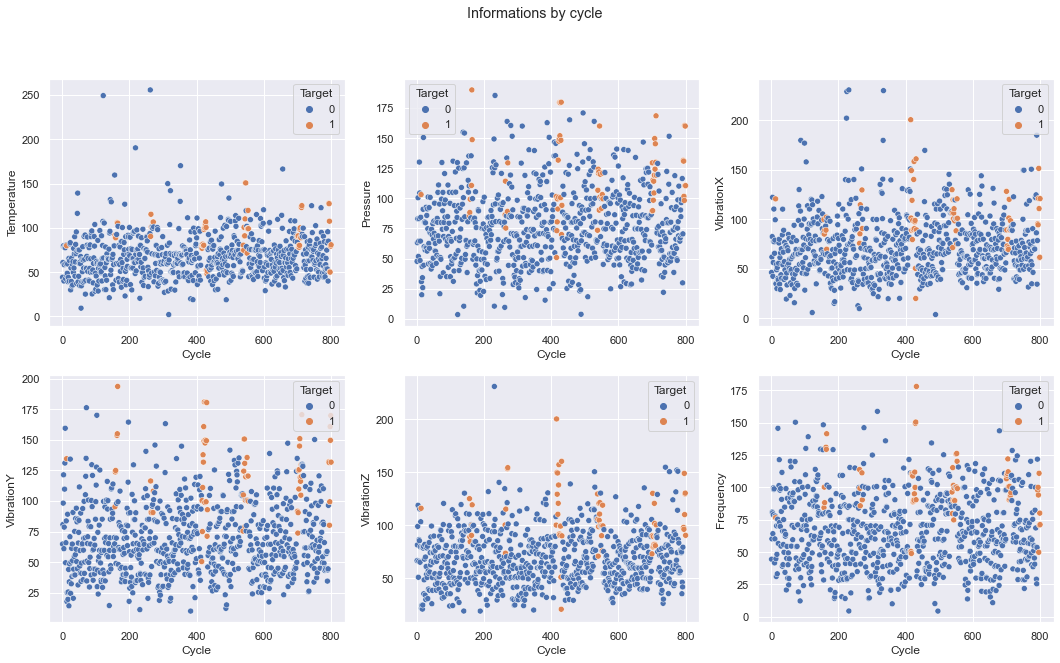

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Informations by cycle')

sns.scatterplot(ax=axes[0, 0], data=df, x='Cycle', y='Temperature', hue='Target')
sns.scatterplot(ax=axes[0, 1], data=df, x='Cycle', y='Pressure', hue='Target')
sns.scatterplot(ax=axes[0, 2], data=df, x='Cycle', y='VibrationX', hue='Target')
sns.scatterplot(ax=axes[1, 0], data=df, x='Cycle', y='VibrationY', hue='Target')
sns.scatterplot(ax=axes[1, 1], data=df, x='Cycle', y='VibrationZ', hue='Target')
sns.scatterplot(ax=axes[1, 2], data=df, x='Cycle', y='Frequency', hue='Target');

<Figure size 2160x2160 with 0 Axes>

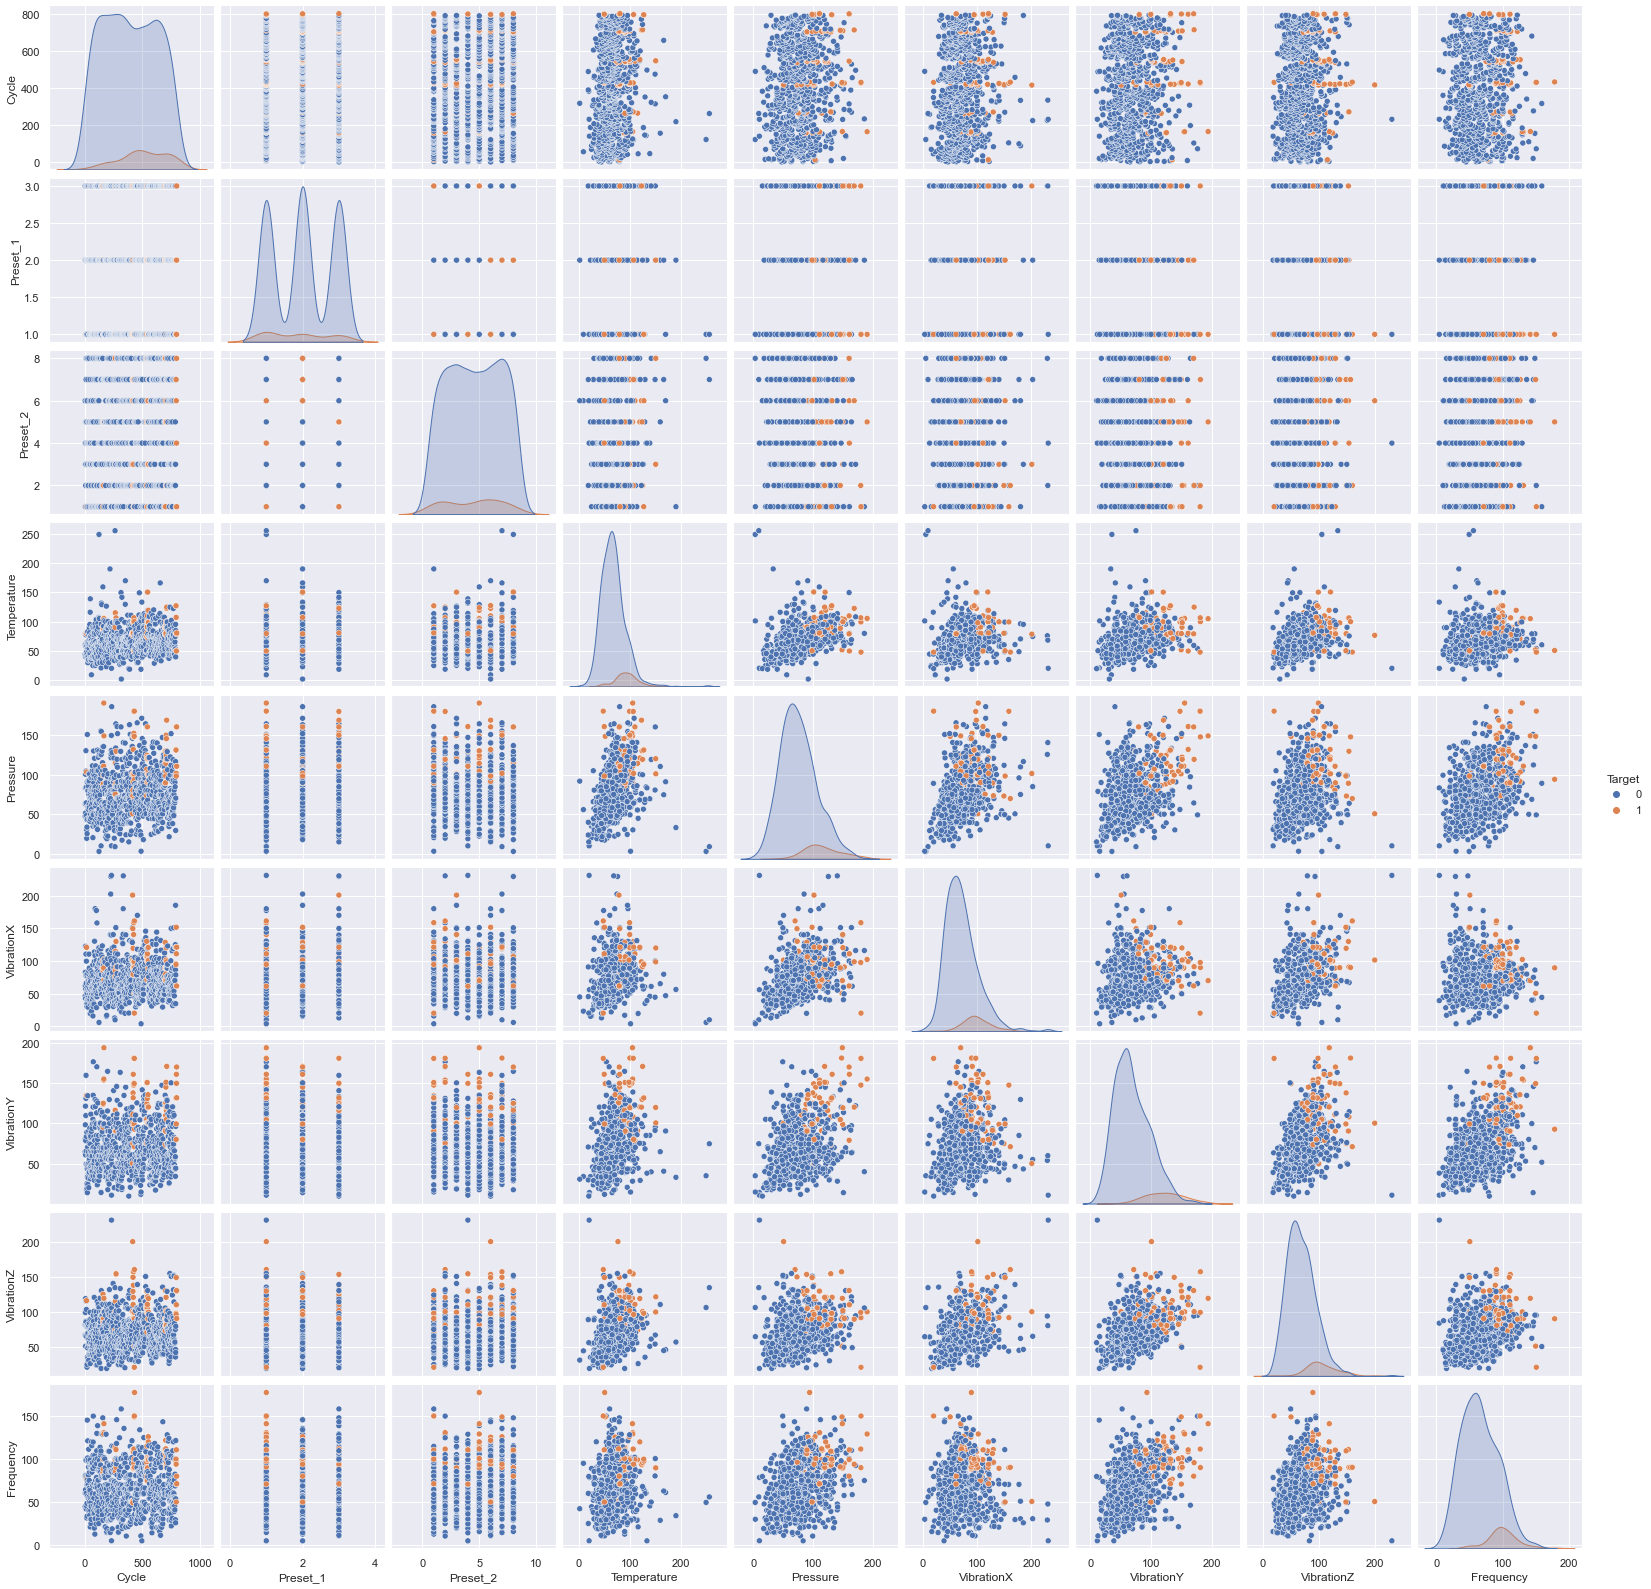

In [22]:
plt.figure(figsize=(30,30))
fig.suptitle("Pairplot of all features")
sns.pairplot(df, hue="Target");

Looking on the graphs above we can visualize the idea of failures occuring with combinations of medium to high values.


About the correlation between features we are testing it below.

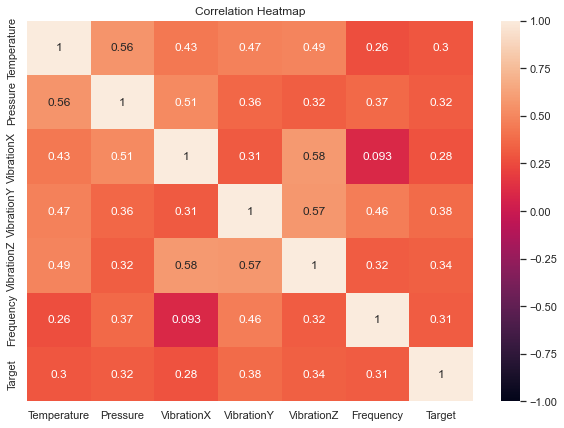

In [23]:
plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df[numerical_cols + ["Target"]].corr(method="spearman"), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap');

We didn't try to check ANOVA because it assumes normality, and neither Kendal because it assumes the categoric value is ordinal.

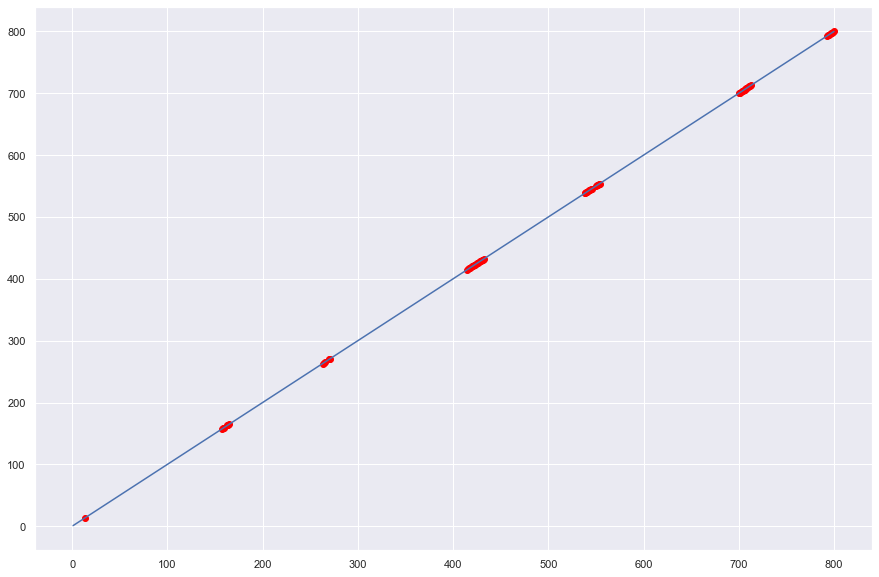

In [13]:
# Here we are going to see how distributed the failures are in the cycles

#all idx
idx_list = df.index.tolist()

# failures idx
fail_idx = list(compress(idx_list, df["Target"]))

fig.suptitle("Failures occuring in cycles")
fig, ax = plt.subplots()
ax.plot(df["Cycle"], df["Cycle"])
for idx in fail_idx:
    ax.scatter(df["Cycle"][idx], df["Cycle"][idx], color="red")

It wasn't clear how each cycle was related to each other, or how close they are in time, but from the index information and this graph it appears that they occured in sequence and from time to time (but not with a periodic component). It seems too sequential to be a coincidence, we must investigate this.

## Investigating a bit futher

In [25]:
fail_idx[:15]

[12, 156, 157, 158, 162, 163, 164, 262, 263, 264, 269, 270, 414, 415, 416]

### Failure chunk #1

It only has one failure, on idx 12

In [26]:
df.loc[:15]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Target,Setup
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,3_6
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,2_4
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,2_1
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,2_3
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,2_5
5,6,1,2,58.336085,64.426353,56.479227,78.623742,65.911528,78.886214,0,1_2
6,7,1,3,77.937777,83.146657,77.800590,109.679048,86.230728,99.681179,0,1_3
7,8,1,4,78.563506,130.089912,110.479871,130.997020,85.218562,98.467375,0,1_4
8,9,3,7,77.486218,104.462955,77.390388,159.423483,115.211934,98.900268,0,3_7
9,10,1,8,42.619159,48.343336,65.789156,49.524829,64.915090,41.620715,0,1_8


Just looking to the numbers sequence I'd be inclined to believe that the Cycle 4 (idx 3) it was too a failure, or even Cycle 8 or 9, because the numbers are not so different from the ones in our failure. Maybe is an influence from the setup? 

After the failure all values were smaller in the next cycle.

### Failure chunk #2

In [27]:
df.loc[150:170]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Target,Setup
150,151,2,8,69.989544,61.271076,123.048531,113.848664,69.264671,53.371189,0,2_8
151,152,3,5,30.303911,80.498461,90.737539,54.580229,45.321520,54.727131,0,3_5
152,153,2,2,58.460124,114.986843,105.554481,62.905361,71.444544,79.460160,0,2_2
153,154,2,2,79.784886,105.117910,66.415906,59.466134,74.273383,129.128825,0,2_2
154,155,3,8,79.583707,135.135115,86.147880,70.127616,95.088050,148.404441,0,3_8
155,156,2,5,159.547402,110.271759,65.147683,64.986749,110.305495,28.411528,0,2_5
156,157,3,1,91.695332,85.345796,99.890670,95.328429,124.970301,84.377355,1,3_1
157,158,2,5,88.916114,88.231887,85.140550,123.711911,88.852872,100.229131,1,2_5
158,159,3,5,88.768766,99.228691,89.109514,124.934221,84.306467,88.218162,1,3_5
159,160,1,7,40.861455,63.670593,45.281481,48.968916,49.987144,49.695767,0,1_7


Here we have two sequences, in the second one a value didn't reduce as in the other cases.
And again, just by looking the values from the failure and the rest it doesn't tell much.

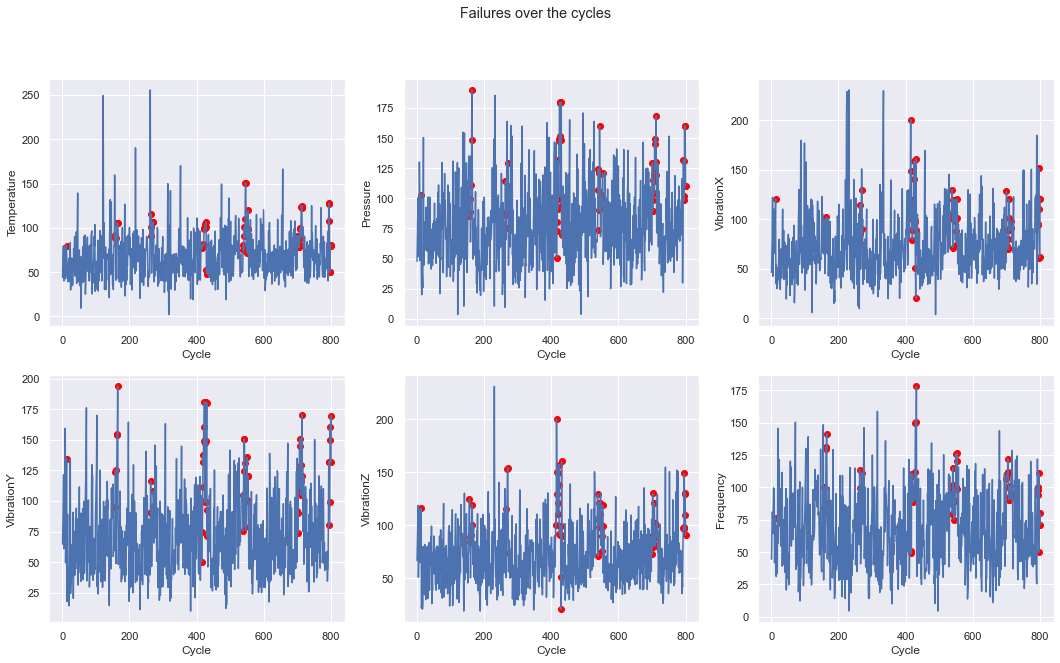

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Failures over the cycles')

sns.lineplot(ax=axes[0, 0], data=df, x='Cycle', y='Temperature')
sns.lineplot(ax=axes[0, 1], data=df, x='Cycle', y='Pressure')
sns.lineplot(ax=axes[0, 2], data=df, x='Cycle', y='VibrationX')
sns.lineplot(ax=axes[1, 0], data=df, x='Cycle', y='VibrationY')
sns.lineplot(ax=axes[1, 1], data=df, x='Cycle', y='VibrationZ')
sns.lineplot(ax=axes[1, 2], data=df, x='Cycle', y='Frequency');


for idx in fail_idx:
    axes[0,0].scatter(df["Cycle"][idx], df["Temperature"][idx], color="red")
    axes[0,1].scatter(df["Cycle"][idx], df["Pressure"][idx], color="red")
    axes[0,2].scatter(df["Cycle"][idx], df["VibrationX"][idx], color="red")
    axes[1,0].scatter(df["Cycle"][idx], df["VibrationY"][idx], color="red")
    axes[1,1].scatter(df["Cycle"][idx], df["VibrationZ"][idx], color="red")
    axes[1,2].scatter(df["Cycle"][idx], df["Frequency"][idx], color="red")


By the graphics we can see that none of the variables explain the failures by itself, so it will be a combination between them.

## Modelling

Here we are going to preprocess out data, test models and validate them.

As it was not possible to transform our data before, we are going to normalize to have the same range, as it affects some models we are testing latter.

In [28]:
#First we need to address the issue of imbalanced data by underesampling it.

df_0 = df[df['Target'] == 0]
df_1 = df[df['Target'] == 1]

num_fail = len(df.loc[df["Target"]==1])

df_0_under = df_0.sample(num_fail, random_state=42)
df_new = pd.concat([df_0_under, df_1], axis=0)

df_new["Target"].value_counts()

0    66
1    66
Name: Target, dtype: int64

In [29]:
df_new.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Target,Setup
603,604,3,5,29.054666,44.725804,58.816833,29.286894,39.646601,57.437696,0,3_5
34,35,2,8,54.590926,45.524517,54.075025,39.468801,39.587827,40.272653,0,2_8
287,288,3,8,76.344691,70.658061,59.901440,49.166316,62.124412,99.437343,0,3_8
205,206,3,5,54.777066,69.910503,54.176914,37.823573,54.988773,85.157282,0,3_5
199,200,3,5,100.428045,49.424432,80.780360,58.538894,80.318343,50.739126,0,3_5


In [30]:
# Separating x and y and split in train and validation
x = df_new.loc[:, df_new.columns != "Target"]
y = df_new["Target"]

# Spliting the data into train and test
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

# Preprocessing for numerical data - normalizing data
numerical_transformer = Normalizer()

# Preprocessing for categorical data - one hot encoding for classes
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# We already have numerical_cols, let's declare categorical_cols
categorical_cols = ["Preset_1", "Preset_1", "Setup"]

# Proprocessing for numerical and categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [31]:
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
df_model = DecisionTreeClassifier(random_state=42)
clf_model = svm.SVC(kernel='linear') 
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

models = [lr_model,rf_model, df_model, clf_model, xgb_model]

In [32]:
def validate_model(pipeline, X, Y, x, y):
    pipeline.fit(X, Y)
    pred = pipeline.predict(x)
    score = mean_absolute_error(y, pred)
    print('MAE:', score)

In [33]:
def test_model(model, preprocessor):
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    scores = -1 * cross_val_score(my_pipeline, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(model)
    print("MAE scores:\n", scores)
    
    print("In validation dataset:")
    
    validate_model(my_pipeline, x_train, y_train, x_val, y_val)
    print("--------------")

In [34]:
for model in models:
    test_model(model, preprocessor)

LogisticRegression(random_state=42)
MAE scores:
 [0.33333333 0.42857143 0.61904762 0.52380952 0.47619048]
In validation dataset:
MAE: 0.5185185185185185
--------------
RandomForestRegressor(random_state=42)
MAE scores:
 [0.45809524 0.41047619 0.39428571 0.45952381 0.40809524]
In validation dataset:
MAE: 0.35703703703703704
--------------
DecisionTreeClassifier(random_state=42)
MAE scores:
 [0.52380952 0.19047619 0.42857143 0.33333333 0.57142857]
In validation dataset:
MAE: 0.4074074074074074
--------------
SVC(kernel='linear')
MAE scores:
 [0.42857143 0.47619048 0.61904762 0.52380952 0.52380952]
In validation dataset:
MAE: 0.48148148148148145
--------------
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
        

Now we are going to create do some feature engineering, so new features to try to improve the xgboost result.
Let's create two kinds of variables:
    - If had failed on the cycle before
    - The difference between two cycles

In [35]:
# Creating the new features

for num_col in numerical_cols:
    df[num_col+"_before"] = df[num_col].shift(1).fillna(df[num_col])
    df[num_col+"_diff"] = (df[num_col] - df[num_col+"_before"])
    
df["Setup_before"] = df["Setup"].shift(1).fillna(df["Setup"])
df["Fail_before"] = df["Target"].shift(1).fillna(0)

In [36]:
# Let's retry it
df_0 = df[df['Target'] == 0]
df_1 = df[df['Target'] == 1]

num_fail = len(df.loc[df["Target"]==1])

df_0_under = df_0.sample(num_fail, random_state=42)
df_new = pd.concat([df_0_under, df_1], axis=0)

x = df_new.loc[:, df_new.columns != "Target"]
y = df_new["Target"]

# Spliting the data into train and test
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

In [37]:
df_new.columns

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Target',
       'Setup', 'Temperature_before', 'Temperature_diff', 'Pressure_before',
       'Pressure_diff', 'VibrationX_before', 'VibrationX_diff',
       'VibrationY_before', 'VibrationY_diff', 'VibrationZ_before',
       'VibrationZ_diff', 'Frequency_before', 'Frequency_diff', 'Setup_before',
       'Fail_before'],
      dtype='object')

In [38]:
categorical_cols = ['Preset_1', 'Preset_2', 'Setup', 'Fail_before', "Setup_before"]
numerical_cols = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency',
                  'Temperature_before', 'Temperature_diff', 'Pressure_before', 'Pressure_diff', 
                  'VibrationX_before', 'VibrationX_diff', 'VibrationY_before', 'VibrationY_diff', 
                  'VibrationZ_before', 'VibrationZ_diff', 'Frequency_before', 'Frequency_diff']

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', xgb_model)])
pipeline_xgb.fit(x_train, y_train)

validate_model(pipeline_xgb, x_train, y_train, x_val, y_val)

MAE: 0.06049033461345567


We improved our model! Now we just need to ajust a threshold for the prediction so we can have as output 0's and 1's.

In [40]:
x_all_test = df_new.loc[:, df_new.columns != "Target"]
pred = pipeline_xgb.predict(x_all_test)

np.set_printoptions(suppress=True)
pred

array([ 0.00029504,  0.00008616, -0.00039845, -0.00034716,  0.03428904,
        0.00040758, -0.00005056,  0.00031205,  0.00007338, -0.00061815,
       -0.02078707,  0.00892404, -0.00001021,  0.00031078,  0.00009841,
        0.00055858, -0.0002114 ,  0.00017548,  0.0228316 , -0.08096351,
        0.00023853, -0.00014868, -0.00020974,  0.00017724,  0.00120957,
        0.00016702,  0.00765115,  0.00547658,  0.00063216,  0.00121357,
        0.00113888,  0.03568342,  0.00015396,  0.00089725, -0.00006272,
       -0.00033814,  0.0258655 ,  0.0010207 ,  0.00033513,  0.00170919,
        0.02308061, -0.00009037, -0.02034532,  0.00046505, -0.01117799,
        0.00036277, -0.00021859,  0.13076258, -0.00067098, -0.00169994,
       -0.0005121 ,  0.00040512, -0.00019134,  0.00023087,  0.00004889,
        0.00167417,  0.06854472,  0.00001176,  0.00057532,  0.00043098,
        0.00087178, -0.00007807, -0.00489035, -0.00011206,  0.17355585,
       -0.03922944,  0.99881446,  0.99894893,  1.000346  ,  1.00

Looking on the predictions we can see that a thershold of 0.9 is a good value

In [41]:
pred_bool = pred >= 0.9
pred_bool = pred_bool.astype(int)

print("Total test data: ", len(pred_bool))
print("Total fails found: ", pred_bool.sum())

Total test data:  132
Total fails found:  65


In [42]:
compare = pred_bool == df_new["Target"]
compare = compare.reset_index(drop=True)
idx_wrong = compare.astype(int).index[compare == 0].values[0]

In [43]:
pred[idx_wrong]

0.10991447

The number above id the score that went wrong.

Let's try to see what happens when we look our train+test dataset

In [44]:
x_all = df.loc[:, df.columns != "Target"]

pred_raw = pipeline_xgb.predict(x_all) 
pred2 = (pred_raw >= 0.9).astype(int)

print("Total test data: ", len(pred2))
print("Total fails found: ", pred2.sum())

Total test data:  800
Total fails found:  72


In [45]:
result_compare = pred2 == df["Target"]

df_compare = pd.concat([df, result_compare], axis=1)
df_compare.loc[~result_compare]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Target,Setup,Temperature_before,Temperature_diff,Pressure_before,Pressure_diff,VibrationX_before,VibrationX_diff,VibrationY_before,VibrationY_diff,VibrationZ_before,VibrationZ_diff,Frequency_before,Frequency_diff,Setup_before,Fail_before,Target
13,14,3,8,46.012191,30.755214,35.021092,17.887608,21.511251,44.889677,0,3_8,79.806509,-33.794318,103.129738,-72.374524,120.753103,-85.732011,134.500905,-116.613297,115.873197,-94.361947,76.562856,-31.673179,1_1,1.0,False
41,42,1,6,95.331395,70.930297,72.918277,94.134247,88.815198,62.291323,0,1_6,70.869794,24.461601,46.082629,24.847667,48.999314,23.918963,60.623288,33.510959,62.398536,26.416663,34.325092,27.966231,1_5,0.0,False
265,266,2,7,48.953067,65.535647,49.748638,46.439025,50.100210,40.795751,0,2_7,100.986610,-52.033543,75.277544,-9.741897,114.859306,-65.110668,90.512733,-44.073708,115.104346,-65.004136,85.794190,-44.998439,3_3,1.0,False
269,270,3,6,106.468516,89.151486,129.768607,90.563206,153.327082,111.281635,1,3_6,99.492158,6.976358,163.840134,-74.688648,151.046505,-21.277899,97.169884,-6.606678,121.180832,32.146250,70.681879,40.599756,1_3,0.0,False
271,272,1,6,100.992611,99.520612,100.177405,101.022048,101.040363,100.807772,0,1_6,106.588913,-5.596302,129.416385,-29.895773,90.798140,9.379265,108.063650,-7.041603,154.255877,-53.215515,90.403491,10.404282,2_4,1.0,False
432,433,3,1,56.253541,66.703714,63.834672,46.094275,56.863150,31.132985,0,3_1,50.962458,5.291083,94.164260,-27.460545,89.448040,-25.613367,92.853324,-46.759048,89.845761,-32.982611,178.090303,-146.957318,1_5,1.0,False
546,547,3,8,119.346538,68.171021,119.705971,75.515210,130.214573,85.572651,0,3_8,150.641059,-31.294521,119.991512,-51.820491,98.508766,21.197204,119.729139,-44.213930,99.565550,30.649023,89.800739,-4.228089,2_3,1.0,False
554,555,3,8,44.926109,45.128385,55.084454,44.829898,54.419924,62.405853,0,3_8,98.979633,-54.053524,99.584189,-54.455804,101.159486,-46.075032,99.830328,-55.000430,99.230568,-44.810644,99.140358,-36.734505,2_3,1.0,False


We only missed one fail and didn't had so many false alarms. Let's check how this model would work on the whole data. To not risk overfitting we are going to look the cross validation score.

In [46]:
y_all = df["Target"]
pipeline_xgb.fit(x_all, y_all)

scores = -1 * cross_val_score(pipeline_xgb, x_all, y_all, cv=5, scoring='neg_mean_absolute_error')
print("MAE scores:\n", scores)

MAE scores:
 [0.03533525 0.04708213 0.04330403 0.04207235 0.02791501]


In [47]:
pred_all_raw = pipeline_xgb.predict(x_all) 
pred_all = (pred_all_raw >= 0.9).astype(int)

print("Total test data: ", len(pred_all))
print("Total fails found: ", pred_all.sum())

Total test data:  800
Total fails found:  66


In [48]:
ultimate_compare = pred_all == df["Target"]
ultimate_compare.value_counts()

True    800
Name: Target, dtype: int64

It was excelent, this model got all answers right! Let's look the feature importance.

/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

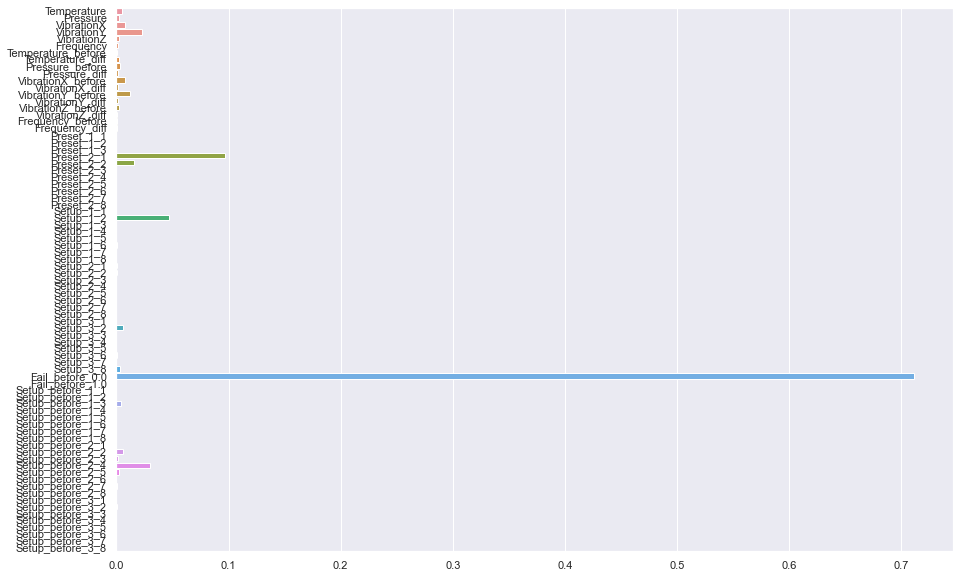

In [49]:
# Getting the categorical columns generated in the preprocessor
cat_cols = pipeline_xgb['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_cols).tolist()

feat_names = numerical_cols + cat_cols

xgb = pipeline_xgb.steps[1][1]
feat_imp = xgb.feature_importances_

sns.barplot(feat_imp, feat_names)

# Turning point

Now that I got at this point of this work I realized that what we really want to know is not if it's a failure or not based on the information, but if it's on the verge of failing, in another words, if the next cycle is a failure.

For te record I'm going to keep the work that was done so far on the notebook, and in the next lines I'm testing the models with this new idea in mind.

In [50]:
df = pd.read_excel("O_G_Equipment_Data.xlsx")
# df["Target"] = df['Fail'].astype(int)
# df.drop("Fail", axis=1, inplace=True)
df["Fail"] = df["Fail"].astype(int)

# Creating a setup feature, it's the combination of Preset_1 and Preset_2
df["Setup"] = df["Preset_1"].astype(str) + "_" + df["Preset_2"].astype(str)


In [51]:
# Featuring Engineering, adding a new feature on the process: the difference 
# (feature on this cycle and on the cycle before) over the value itself in this cycle.

numerical_cols_original = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

for num_col in numerical_cols_original:
    df[num_col+"_before"] = df[num_col].shift(1).fillna(df[num_col])
    df[num_col+"_diff"] = (df[num_col] - df[num_col+"_before"])
    df[num_col+"_diff_prop"] = df[num_col+"_diff"]/df[num_col]
    
df["Setup_before"] = df["Setup"].shift(1).fillna(df["Setup"])
df["Fail_before"] = df["Fail"].shift(1).fillna(0)

# Changing the target
# df.rename(columns={"Target":"Fail"}, inplace=True)
df["Target"] = df["Fail"].shift(-1).fillna(0)

df.head(15)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Setup,Temperature_before,Temperature_diff,Temperature_diff_prop,Pressure_before,Pressure_diff,Pressure_diff_prop,VibrationX_before,VibrationX_diff,VibrationX_diff_prop,VibrationY_before,VibrationY_diff,VibrationY_diff_prop,VibrationZ_before,VibrationZ_diff,VibrationZ_diff_prop,Frequency_before,Frequency_diff,Frequency_diff_prop,Setup_before,Fail_before,Target
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,3_6,44.235186,0.000000,0.000000,47.657254,0.000000,0.000000,46.441769,0.000000,0.000000,64.820327,0.000000,0.000000,66.454520,0.000000,0.000000,44.483250,0.000000,0.000000,3_6,0.0,0.0
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,2_4,44.235186,16.572049,0.272534,47.657254,15.514822,0.245596,46.441769,15.564182,0.251011,64.820327,15.894104,0.196918,66.454520,14.791885,0.182062,44.483250,15.745465,0.261428,3_6,0.0,0.0
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,2_1,60.807234,18.220301,0.230556,63.172076,19.860114,0.239186,62.005951,20.636159,0.249705,80.714431,17.539955,0.178516,81.246405,17.538791,0.177545,60.228715,20.764764,0.256376,2_4,0.0,0.0
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,2_3,79.027536,0.688706,0.008639,83.032190,17.476445,0.173880,82.642110,39.720212,0.324611,98.254386,23.109043,0.190412,98.785196,19.867342,0.167441,80.993479,-0.677913,-0.008441,2_1,0.0,0.0
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,2_5,79.716242,-39.727187,-0.993452,100.508634,-48.743801,-0.941639,122.362321,-79.848020,-1.878145,121.363429,-60.325518,-0.988329,118.652538,-67.936069,-1.339527,80.315567,-16.070401,-0.250142,2_3,0.0,0.0
5,6,1,2,58.336085,64.426353,56.479227,78.623742,65.911528,78.886214,0,1_2,39.989054,18.347031,0.314506,51.764833,12.661520,0.196527,42.514302,13.964925,0.247258,61.037910,17.585832,0.223671,50.716469,15.195059,0.230537,64.245166,14.641048,0.185597,2_5,0.0,0.0
6,7,1,3,77.937777,83.146657,77.800590,109.679048,86.230728,99.681179,0,1_3,58.336085,19.601692,0.251504,64.426353,18.720303,0.225148,56.479227,21.321363,0.274051,78.623742,31.055306,0.283147,65.911528,20.319200,0.235638,78.886214,20.794965,0.208615,1_2,0.0,0.0
7,8,1,4,78.563506,130.089912,110.479871,130.997020,85.218562,98.467375,0,1_4,77.937777,0.625728,0.007965,83.146657,46.943255,0.360852,77.800590,32.679282,0.295794,109.679048,21.317972,0.162736,86.230728,-1.012166,-0.011877,99.681179,-1.213804,-0.012327,1_3,0.0,0.0
8,9,3,7,77.486218,104.462955,77.390388,159.423483,115.211934,98.900268,0,3_7,78.563506,-1.077288,-0.013903,130.089912,-25.626956,-0.245321,110.479871,-33.089483,-0.427566,130.997020,28.426463,0.178308,85.218562,29.993372,0.260332,98.467375,0.432893,0.004377,1_4,0.0,0.0
9,10,1,8,42.619159,48.343336,65.789156,49.524829,64.915090,41.620715,0,1_8,77.486218,-34.867059,-0.818108,104.462955,-56.119620,-1.160855,77.390388,-11.601233,-0.176340,159.423483,-109.898654,-2.219062,115.211934,-50.296844,-0.774810,98.900268,-57.279554,-1.376227,3_7,0.0,0.0


Now we are walking on the right direction.

In [52]:
df.columns

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail', 'Setup',
       'Temperature_before', 'Temperature_diff', 'Temperature_diff_prop',
       'Pressure_before', 'Pressure_diff', 'Pressure_diff_prop',
       'VibrationX_before', 'VibrationX_diff', 'VibrationX_diff_prop',
       'VibrationY_before', 'VibrationY_diff', 'VibrationY_diff_prop',
       'VibrationZ_before', 'VibrationZ_diff', 'VibrationZ_diff_prop',
       'Frequency_before', 'Frequency_diff', 'Frequency_diff_prop',
       'Setup_before', 'Fail_before', 'Target'],
      dtype='object')

In [53]:
df['Target'].value_counts()

0.0    734
1.0     66
Name: Target, dtype: int64

In [54]:
#First we need to address the issue of imbalanced data by underesampling it.

df_0 = df[df['Target'] == 0]
df_1 = df[df['Target'] == 1]

num_fail = len(df.loc[df["Target"]==1])

df_0_under = df_0.sample(num_fail, random_state=42)
df_new = pd.concat([df_0_under, df_1], axis=0)

# Separating x and y and split in train and validation
x = df_new.loc[:, df_new.columns != "Target"]
y = df_new["Target"]

# Spliting the data into train and test
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

# Preprocessing for numerical data - normalizing data
numerical_transformer = Normalizer()

# Preprocessing for categorical data - one hot encoding for classes
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_cols = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency',
        'Temperature_before', 'Temperature_diff', 'Temperature_diff_prop','Pressure_before', 'Pressure_diff', 
        'Pressure_diff_prop', 'VibrationX_before', 'VibrationX_diff', 'VibrationX_diff_prop', 'VibrationY_before', 
        'VibrationY_diff', 'VibrationY_diff_prop', 'VibrationZ_before', 'VibrationZ_diff', 'VibrationZ_diff_prop',
        'Frequency_before', 'Frequency_diff', 'Frequency_diff_prop']
categorical_cols = ["Preset_1", "Preset_1", "Setup", "Fail", "Fail_before", "Setup_before"]

# Proprocessing for numerical and categorical
new_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [55]:
for model in models:
    my_pipeline = Pipeline(steps=[('preprocessor', new_preprocessor),
                                  ('model', model)])
    scores = -1 * cross_val_score(my_pipeline, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(model)
    print("MAE: ", scores)

LogisticRegression(random_state=42)
MAE:  [0.19047619 0.19047619 0.04761905 0.         0.04761905]
RandomForestRegressor(random_state=42)
MAE:  [0.19       0.15238095 0.13142857 0.09714286 0.10190476]
DecisionTreeClassifier(random_state=42)
MAE:  [0.28571429 0.14285714 0.19047619 0.         0.19047619]
SVC(kernel='linear')
MAE:  [0.14285714 0.14285714 0.0952381  0.         0.14285714]
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1

Let's take a look in the first model and see where it went wrong.

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pipeline_lr = Pipeline(steps=[('preprocessor', new_preprocessor),
                                  ('model', lr_model)])
pipeline_lr.fit(x_train, y_train)

validate_model(pipeline_lr, x_train, y_train, x_val, y_val)

MAE: 0.037037037037037035


In [57]:
x_all_test = df_new.loc[:, df_new.columns != "Target"]
pred = pipeline_lr.predict(x_all_test)

print("Total test data: ", len(pred))
print("Total fails found: ", pred.sum())

Total test data:  132
Total fails found:  59.0


In [58]:
result_compare = pred == df_new["Target"]
df_new.loc[~result_compare]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Setup,Temperature_before,Temperature_diff,Temperature_diff_prop,Pressure_before,Pressure_diff,Pressure_diff_prop,VibrationX_before,VibrationX_diff,VibrationX_diff_prop,VibrationY_before,VibrationY_diff,VibrationY_diff_prop,VibrationZ_before,VibrationZ_diff,VibrationZ_diff_prop,Frequency_before,Frequency_diff,Frequency_diff_prop,Setup_before,Fail_before,Target
161,162,2,2,92.501581,135.281156,93.375889,98.142823,100.395385,80.535575,0,2_2,59.566279,32.935303,0.356051,83.777553,51.503603,0.380715,64.652909,28.722979,0.307606,69.696556,28.446267,0.289846,70.099087,30.296298,0.301770,68.621322,11.914253,0.147938,1_5,0.0,1.0
261,262,1,7,255.607829,9.455314,9.873129,74.813923,134.394037,55.798757,0,1_7,93.552988,162.054841,0.633998,80.199785,-70.744471,-7.481980,105.807657,-95.934528,-9.716729,39.600426,35.213497,0.470681,70.297916,64.096121,0.476927,99.911583,-44.112826,-0.790570,1_3,0.0,1.0
268,269,1,3,99.492158,163.840134,151.046505,97.169884,121.180832,70.681879,0,1_3,101.425593,-1.933435,-0.019433,133.489833,30.350302,0.185243,111.238549,39.807956,0.263548,95.735918,1.433965,0.014757,97.597540,23.583293,0.194612,61.513865,9.168015,0.129708,3_3,0.0,1.0
413,414,2,5,80.473472,145.618925,151.023102,104.436732,108.042431,111.173779,0,2_5,78.356424,2.117048,0.026307,135.372439,10.246486,0.070365,128.285933,22.737169,0.150554,93.402276,11.034457,0.105657,89.278701,18.763730,0.173670,71.380136,39.793643,0.357941,1_7,0.0,1.0
536,537,2,2,51.066026,64.956758,107.778720,105.890865,104.183568,85.022554,0,2_2,51.894226,-0.828200,-0.016218,63.674218,1.282540,0.019745,107.898539,-0.119818,-0.001112,104.312738,1.578127,0.014903,105.788197,-1.604630,-0.015402,87.397045,-2.374490,-0.027928,2_8,0.0,1.0
548,549,3,2,101.700079,99.775886,100.856559,100.734110,99.150327,100.359491,0,3_2,78.749469,22.950609,0.225670,79.986866,19.789020,0.198335,78.978660,21.877900,0.216921,79.946338,20.787772,0.206363,80.700034,18.450293,0.186084,79.440175,20.919317,0.208444,2_5,0.0,1.0
791,792,2,7,84.990752,70.507201,78.673752,96.382638,79.131822,121.850581,0,2_7,39.909918,45.080834,0.530420,29.797831,40.709370,0.577379,34.575632,44.098120,0.560519,44.560622,51.822016,0.537670,41.588444,37.543378,0.474441,53.584668,68.265913,0.560243,3_7,0.0,1.0


We had 7 cases that were real fails and the model didn't find them. 
We should take into account that this model's output was already 0 and 1's, but the others are floats, so let's make everyone into 0 and 1's to compare the MAE again.

In [59]:
def validate_model_2(pipeline, X, Y, x, y):
    pipeline.fit(X, Y)
    pred = pipeline.predict(x)
    
    pred_bool = pred >= 0.9
    pred_bool = pred_bool.astype(int)
    score = mean_absolute_error(y*100, pred_bool*100)
    print('MAE:', score)

In [60]:
for model in models:
    print(model)
    pipeline_val = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    validate_model_2(pipeline_val, x_train, y_train, x_val, y_val)

LogisticRegression(random_state=42)
MAE: 3.7037037037037037
RandomForestRegressor(random_state=42)
MAE: 3.7037037037037037
DecisionTreeClassifier(random_state=42)
MAE: 7.407407407407407
SVC(kernel='linear')
MAE: 7.407407407407407
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
MAE: 3.7037037037037037


As we can see here it seems that Random Forest and XGBoost are also good options.

In [61]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

pipeline_x = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', xgb_model)])

pipeline_x.fit(x_train, y_train)
pred_x = pipeline_x.predict(x_all_test)

print("Total test data: ", len(pred_x))
print("Total fails found: ", pred_x.sum())

print(" --- ")

pred_bool = pred_x >= 0.9
pred_bool = pred_bool.astype(int)

print("Total test data: ", len(pred_bool))
print("Total fails found: ", pred_bool.sum())

Total test data:  132
Total fails found:  66.66602
 --- 
Total test data:  132
Total fails found:  65


In [62]:
result_compare = pred_bool == df_new["Target"]

df_compare = pd.concat([df_new, result_compare], axis=1)
df_compare.loc[~result_compare]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Setup,Temperature_before,Temperature_diff,Temperature_diff_prop,Pressure_before,Pressure_diff,Pressure_diff_prop,VibrationX_before,VibrationX_diff,VibrationX_diff_prop,VibrationY_before,VibrationY_diff,VibrationY_diff_prop,VibrationZ_before,VibrationZ_diff,VibrationZ_diff_prop,Frequency_before,Frequency_diff,Frequency_diff_prop,Setup_before,Fail_before,Target,Target
268,269,1,3,99.492158,163.840134,151.046505,97.169884,121.180832,70.681879,0,1_3,101.425593,-1.933435,-0.019433,133.489833,30.350302,0.185243,111.238549,39.807956,0.263548,95.735918,1.433965,0.014757,97.59754,23.583293,0.194612,61.513865,9.168015,0.129708,3_3,0.0,1.0,False


In [63]:
x_all = df.loc[:, df_new.columns != "Target"]
pred_x = pipeline_x.predict(x_all)
pred_bool = pred_x >= 0.9
pred_bool = pred_bool.astype(int)

print("Total test data: ", len(pred_bool))
print("Total fails found: ", pred_bool.sum())

Total test data:  800
Total fails found:  80


In [64]:
result_compare = pred_bool == df["Target"]

df_compare = pd.concat([df, result_compare], axis=1)
df_compare.loc[~result_compare]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Setup,Temperature_before,Temperature_diff,Temperature_diff_prop,Pressure_before,Pressure_diff,Pressure_diff_prop,VibrationX_before,VibrationX_diff,VibrationX_diff_prop,VibrationY_before,VibrationY_diff,VibrationY_diff_prop,VibrationZ_before,VibrationZ_diff,VibrationZ_diff_prop,Frequency_before,Frequency_diff,Frequency_diff_prop,Setup_before,Fail_before,Target,Target
12,13,1,1,79.806509,103.129738,120.753103,134.500905,115.873197,76.562856,1,1_1,80.662497,-0.855987,-0.010726,84.273464,18.856274,0.182840,99.628778,21.124325,0.174938,83.701907,50.798998,0.377685,103.141044,12.732153,0.109880,77.888370,-1.325514,-0.017313,2_5,0.0,0.0,False
158,159,3,5,88.768766,99.228691,89.109514,124.934221,84.306467,88.218162,1,3_5,88.916114,-0.147348,-0.001660,88.231887,10.996804,0.110823,85.140550,3.968964,0.044540,123.711911,1.222310,0.009784,88.852872,-4.546405,-0.053927,100.229131,-12.010969,-0.136151,2_5,1.0,0.0,False
164,165,1,5,105.275191,148.700443,69.876415,193.569947,119.136068,141.502855,1,1_5,105.695331,-0.420139,-0.003991,189.995681,-41.295238,-0.277708,102.272191,-32.395776,-0.463615,154.904461,38.665486,0.199749,99.773163,19.362905,0.162528,129.475094,12.027761,0.085000,1_5,1.0,0.0,False
201,202,3,3,89.386473,74.389889,73.930272,90.475313,99.653017,69.211502,0,3_3,68.502021,20.884452,0.233642,100.951185,-26.561296,-0.357055,115.382716,-41.452444,-0.560696,28.757459,61.717855,0.682151,65.008119,34.644898,0.347655,28.133177,41.078324,0.593519,3_8,0.0,0.0,False
264,265,3,3,100.986610,75.277544,114.859306,90.512733,115.104346,85.794190,1,3_3,115.278603,-14.291994,-0.141524,114.229505,-38.951961,-0.517445,85.462742,29.396564,0.255935,90.980967,-0.468234,-0.005173,73.479125,41.625221,0.361630,99.284994,-13.490804,-0.157246,1_8,1.0,0.0,False
268,269,1,3,99.492158,163.840134,151.046505,97.169884,121.180832,70.681879,0,1_3,101.425593,-1.933435,-0.019433,133.489833,30.350302,0.185243,111.238549,39.807956,0.263548,95.735918,1.433965,0.014757,97.597540,23.583293,0.194612,61.513865,9.168015,0.129708,3_3,0.0,1.0,False
270,271,2,4,106.588913,129.416385,90.798140,108.063650,154.255877,90.403491,1,2_4,106.468516,0.120397,0.001130,89.151486,40.264898,0.311127,129.768607,-38.970467,-0.429199,90.563206,17.500445,0.161946,153.327082,0.928795,0.006021,111.281635,-20.878144,-0.230944,3_6,1.0,0.0,False
306,307,2,5,67.279047,84.367136,64.376308,163.146820,133.227181,100.349909,0,2_5,69.814411,-2.535364,-0.037684,65.396555,18.970581,0.224857,64.960390,-0.584081,-0.009073,123.187499,39.959320,0.244929,113.256278,19.970903,0.149901,80.672943,19.676966,0.196084,1_5,0.0,0.0,False
366,367,2,5,75.878205,111.438864,109.276309,110.652647,105.116292,79.271093,0,2_5,74.022541,1.855664,0.024456,70.531314,40.907550,0.367085,88.411979,20.864331,0.190932,70.542123,40.110524,0.362490,105.550589,-0.434297,-0.004132,80.189018,-0.917925,-0.011580,2_5,0.0,0.0,False
431,432,1,5,50.962458,94.164260,89.448040,92.853324,89.845761,178.090303,1,1_5,48.171371,2.791088,0.054768,69.923414,24.240846,0.257431,161.188743,-71.740704,-0.802038,71.189361,21.663962,0.233314,160.239558,-70.393797,-0.783496,90.470580,87.619723,0.491996,1_2,1.0,0.0,False


So our model works fine, it only missed one failure and didn't have many false positives.

/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

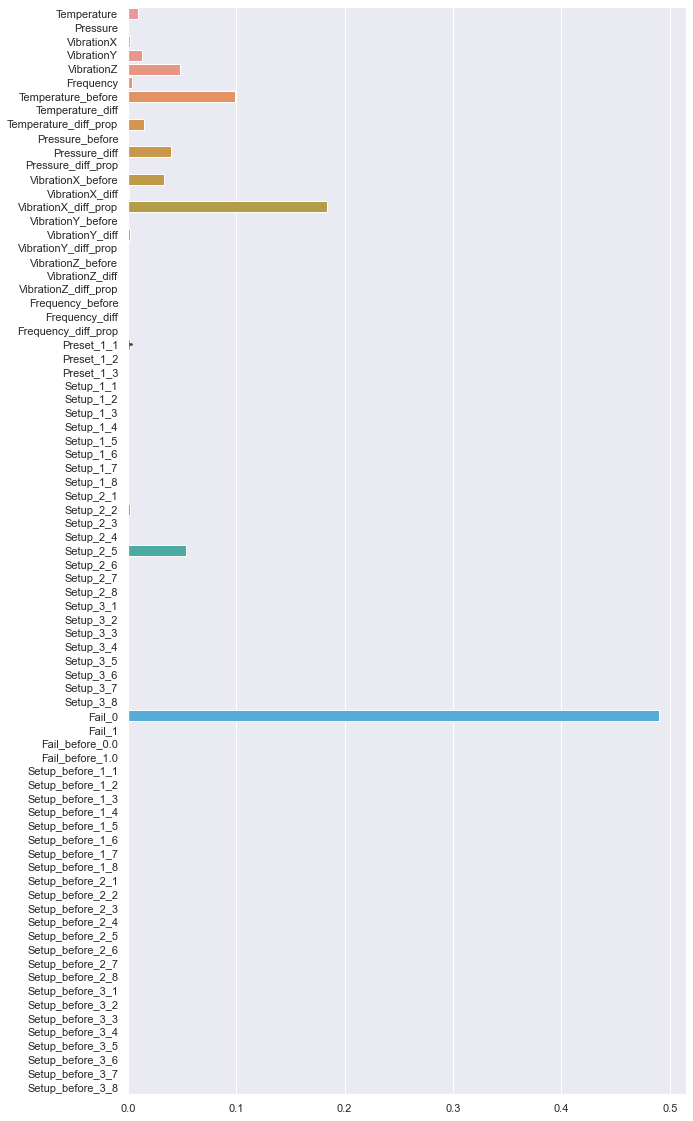

In [65]:
# Getting the categorical columns generated in the preprocessor
cat_cols = pipeline_x['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_cols).tolist()

feat_names = numerical_cols + cat_cols

xgb = pipeline_x.steps[1][1]
feat_imp = xgb.feature_importances_

plt.figure(figsize=(10,20))
sns.barplot(feat_imp, feat_names)

Let's take a look on the feature importance. We can see that the information that it failed is really important, but it's expected since most of our data will have 0 in the target and one in the fail_0 feature.
From the setups we can see that 2_5 is the most relevant one, as we don't know how those setup works, or if we know the ones from the next step.
And from the graphic we can see that the 3 most important features from the numerical ones are the proportion on VibrationX, Pressure difference and VibrationZ.


Let's take it for one more round and try with only relevant features.

In [66]:
df_0 = df[df['Target'] == 0]
df_1 = df[df['Target'] == 1]

num_fail = len(df.loc[df["Target"]==1])

df_0_under = df_0.sample(num_fail, random_state=42)
df_new = pd.concat([df_0_under, df_1], axis=0)

# Separating x and y and split in train and validation
x = df_new.loc[:, df_new.columns != "Target"]
y = df_new["Target"]

# Spliting the data into train and test
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

In [68]:
numerical_cols = ['Temperature', 'VibrationY', 'VibrationZ', 'Temperature_before', 'Temperature_diff_prop',
                 'Pressure_diff', 'VibrationX_before', 'VibrationX_diff_prop']
categorical_cols = ['Setup', 'Fail']

new_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
pipeline_final = Pipeline(steps=[('preprocessor', new_preprocessor),
                                  ('model', xgb_model)])
pipeline_final.fit(x_train, y_train)

validate_model(pipeline_final, x_train, y_train, x_val, y_val)

MAE: 0.1549561424038041


In [69]:
x_all_test = df_new.loc[:, df_new.columns != "Target"]
pred_x = pipeline_final.predict(x_all_test)

print("Total test data: ", len(pred_x))
print("Total fails found: ", pred_x.sum())

print(" --- ")

pred_bool = pred_x >= 0.9
pred_bool = pred_bool.astype(int)

print("Total test data: ", len(pred_bool))
print("Total fails found: ", pred_bool.sum())

Total test data:  132
Total fails found:  68.524055
 --- 
Total test data:  132
Total fails found:  66


In [70]:
result_compare = pred_bool == df_new["Target"]

df_compare = pd.concat([df_new, result_compare], axis=1)
df_compare.loc[~result_compare]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Setup,Temperature_before,Temperature_diff,Temperature_diff_prop,Pressure_before,Pressure_diff,Pressure_diff_prop,VibrationX_before,VibrationX_diff,VibrationX_diff_prop,VibrationY_before,VibrationY_diff,VibrationY_diff_prop,VibrationZ_before,VibrationZ_diff,VibrationZ_diff_prop,Frequency_before,Frequency_diff,Frequency_diff_prop,Setup_before,Fail_before,Target,Target
257,258,3,4,44.707300,29.592167,12.762317,85.114876,63.891355,63.396592,0,3_4,51.511066,-6.803767,-0.152185,96.344644,-66.752476,-2.255748,95.681205,-82.918888,-6.497165,33.504302,51.610574,0.606364,111.45753,-47.566175,-0.744485,73.470738,-10.074146,-0.158907,1_5,0.0,0.0,False
268,269,1,3,99.492158,163.840134,151.046505,97.169884,121.180832,70.681879,0,1_3,101.425593,-1.933435,-0.019433,133.489833,30.350302,0.185243,111.238549,39.807956,0.263548,95.735918,1.433965,0.014757,97.59754,23.583293,0.194612,61.513865,9.168015,0.129708,3_3,0.0,1.0,False


In [71]:
x_all = df.loc[:, df_new.columns != "Target"]
pred_x = pipeline_final.predict(x_all)
pred_bool = pred_x >= 0.9
pred_bool = pred_bool.astype(int)

print("Total test data: ", len(pred_bool))
print("Total fails found: ", pred_bool.sum())

Total test data:  800
Total fails found:  78


/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/lilimartins/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

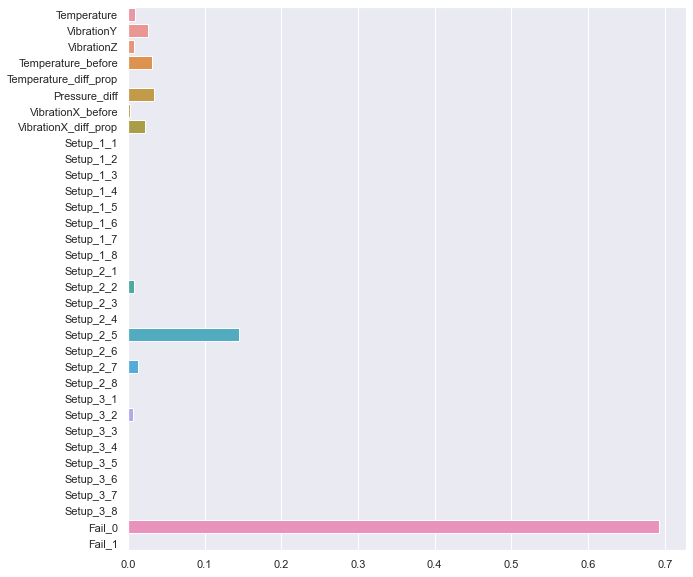

In [72]:
# Getting the categorical columns generated in the preprocessor
cat_cols = pipeline_final['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_cols).tolist()

feat_names = numerical_cols + cat_cols

xgb = pipeline_final.steps[1][1]
feat_imp = xgb.feature_importances_

plt.figure(figsize=(10,10))
sns.barplot(feat_imp, feat_names)

In this notebook we explored the dataset and found out interesting things about our data, and that we can predict with some confidence if a cycle will be a failure based on the one before. Hope you had a good time reading this work!